In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import einops
import circuitsvis as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from transformer_lens import ActivationCache
from src import *

# Load Patching Results to find best heads

In [3]:
def top_k_indices_argsort(heatmap, k):
    # Flatten the array and get the sorted indices
    flat_indices = np.argsort(heatmap, axis=None)[::-1]
    # Get the top k indices in the flattened array
    top_k_flat_indices = flat_indices[:k]
    # Convert flat indices to 2D indices
    top_k_indices = np.unravel_index(top_k_flat_indices, heatmap.shape)
    # Get the top k values
    top_k_values = heatmap[top_k_indices]
    # Zip the indices and values together
    top_k = list(zip(zip(*top_k_indices), top_k_values))
    return top_k

### Heads found when patching sequences

In [4]:
seq_heatmap = torch.load("z_patching_results_unbatched_-1_alt.pt")
seq_heatmap = np.array(seq_heatmap).mean(axis=0)

seq_important_attn_heads = top_k_indices_argsort(seq_heatmap, 10)
print(seq_important_attn_heads)

[((16, 39), 0.775537109375), ((17, 2), 0.3317626953125), ((15, 21), 0.196845703125), ((19, 36), 0.1629931640625), ((21, 7), 0.144482421875), ((18, 18), 0.11525390625), ((14, 28), 0.105408935546875), ((16, 21), 0.083712158203125), ((15, 37), 0.081634521484375), ((17, 7), 0.07854248046875)]


### Heads found when patching personas

In [51]:
len_to_harsh_heatmap = torch.load("z_patching_results_unbatched_lenient_to_harsh_-1.pt")
len_to_harsh_heatmap = np.array(len_to_harsh_heatmap).mean(axis=0)

len_to_harsh_important_attn_heads = top_k_indices_argsort(len_to_harsh_heatmap, 10)
print(len_to_harsh_important_attn_heads)

[((14, 39), 0.3401953125), ((18, 18), 0.207322998046875), ((19, 36), 0.189423828125), ((21, 7), 0.168125), ((15, 17), 0.141875), ((17, 2), 0.128612060546875), ((23, 13), 0.1140771484375), ((20, 18), 0.10572021484375), ((17, 7), 0.1009716796875), ((16, 39), 0.08544921875)]


In [52]:
harsh_to_lenient_heatmap = torch.load("z_patching_results_unbatched_harsh_to_lenient_-1.pt")
harsh_to_lenient_heatmap = np.array(harsh_to_lenient_heatmap).mean(axis=0)

harsh_to_lenient_important_attn_heads = top_k_indices_argsort(harsh_to_lenient_heatmap, 10)
print(harsh_to_lenient_important_attn_heads)

[((14, 39), 0.258681640625), ((18, 18), 0.227254638671875), ((19, 36), 0.19310546875), ((21, 7), 0.1647119140625), ((17, 2), 0.149576416015625), ((20, 18), 0.120126953125), ((15, 17), 0.1165380859375), ((17, 7), 0.11167724609375), ((23, 13), 0.1053076171875), ((16, 39), 0.09455322265625)]


# Load Model

In [5]:
torch.set_grad_enabled(False) 

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, "llama-13b")
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Load dataset

In [ ]:
personas = {
    "lenient": "You are lenient on toxicity\n",
    "harsh": "You are harsh on toxicity\n"
}

possible_labels = ("CLEAN", "TOXIC")

classifier_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you.

Here is the text:
{sequence}

Your response:
("""

In [ ]:
toxicity_data = pd.read_json("data/simple_toxic_data_filtered.jsonl", lines=True)
sequences = toxicity_data["prompt"].tolist()

# Helpers

In [9]:
toxic_sequence = toxicity_data[toxicity_data["label"] == "toxic"]["prompt"].iloc[0]
clean_sequence = toxicity_data[toxicity_data["label"] == "clean"]["prompt"].iloc[0]

harsh_toxic_prompt = personas["harsh"] + classifier_prompt.format(sequence=toxic_sequence)
harsh_clean_prompt = personas["harsh"] + classifier_prompt.format(sequence=clean_sequence)
lenient_toxic_prompt = personas["lenient"] + classifier_prompt.format(sequence=toxic_sequence)
lenient_clean_prompt = personas["lenient"] + classifier_prompt.format(sequence=clean_sequence)

In [10]:
harsh_toxic_logits, harsh_toxic_cache = model.run_with_cache(harsh_toxic_prompt)
harsh_clean_logits, harsh_clean_cache = model.run_with_cache(harsh_clean_prompt)
lenient_toxic_logits, lenient_toxic_cache = model.run_with_cache(lenient_toxic_prompt)
lenient_clean_logits, lenient_clean_cache = model.run_with_cache(lenient_clean_prompt)

In [26]:
def viualize_attn_pattern_for_important_head(model, prompt, head):
    _, cache = model.run_with_cache(prompt)
    return cv.attention.attention_patterns(
        tokens=model.to_str_tokens(prompt), 
        attention=cache["pattern", head[0], "attn"][0, head[1], :, :][None, :, :],
    )


In [45]:
seq_important_head1 = seq_important_attn_heads[0][0]
seq_important_head2 = seq_important_attn_heads[1][0]
seq_important_head3 = seq_important_attn_heads[2][0]
seq_important_head4 = seq_important_attn_heads[3][0]
seq_important_head5 = seq_important_attn_heads[4][0]

# Attn Head Logit Attribution

In [107]:
l16h39_wo_attribution = model.unembed(model.blocks[16].attn.W_O[39][None, :, :])[0]

In [120]:
for i in range(128):
    _, top10_ids = torch.topk(l16h39_wo_attribution[i], 10)
    print(model.tokenizer.decode(top10_ids))

conc stri white白 priv Concwhite secre cliiska
solo Solodig dry reduction stripstrip Replaceberger Ster
unique uniqu uniqueadded isol imped添 addedantal remote
cancel slowcancel backupCancel shut Dup retro back backwards
warm mobile aheadadel resid flex aliveCompleted readinglich
gentlerund sympath moth soft asp romnel gent sympathy
patri blind obst pridefter motiv emot compens FelELD
relax ease exped deviation individual isolated independently separated comfort easy
quiet modern quietly silent smooth clos retain dus silence darkness
restrict interrupt magn debut Magn vert seg alert sudden rig
limitations safety limit restrict constraints protect limitation protection limits restrictions
comfortflat convenienceirtual flatrelax shelter仮遠aires
flex quiet independence Independ flexible shelter quietly escapeendar sudden
indo closedikan further arbitr leadershipclosed arbitrary control❯
relax rescue alle relief slowrelaxoba heroanja fixed
infl causing emot raising trigger alarm causa Active 

In [105]:
attn_result = einops.einsum(harsh_toxic_cache['blocks.16.attn.hook_z'][0], model.blocks[16].attn.W_O, "s n h, n h e -> s n e")
attr = model.unembed(attn_result[-1, 39][None, None, :])[0, 0]
_, top10_ids = torch.topk(attr, 10)
print(model.tokenizer.decode(top10_ids))

negativeikannegative destruct violent quick Neg violence hate neg


In [106]:
attn_result = einops.einsum(lenient_clean_cache['blocks.16.attn.hook_z'][0], model.blocks[16].attn.W_O, "s n h, n h e -> s n e")
attr = model.unembed(attn_result[-1, 39][None, None, :])[0, 0]
_, top10_ids = torch.topk(attr, 10)
print(model.tokenizer.decode(top10_ids))

innoc positive peace pleasant calm comfort safe bland posit relax


# Check Cosine Sim of Attention Head Outputs with Representations

In [ ]:
def get_attn_head_outputs_cosine_sim(representation, layer, position, n=40):

    toxic_sequences = toxicity_data[toxicity_data["label"] == "toxic"]["prompt"].tolist()[:n]
    clean_sequences = toxicity_data[toxicity_data["label"] == "clean"]["prompt"].tolist()[:n]

    head_rep_writing_scores_toxic = defaultdict(list)
    head_rep_writing_scores_clean = defaultdict(list)

    for sequence in tqdm(toxic_sequences):
        prompt = personas["harsh"] + classifier_prompt.format(sequence=sequence)
        logits, cache = model.run_with_cache(prompt) 
        for head in range(40):
            attn_result = einops.einsum(cache[f'blocks.{layer}.attn.hook_z'][0], model.blocks[layer].attn.W_O, "s n h, n h e -> s n e")
            rep_writing_score = attn_result[position, head] @ representation[0]
            head_rep_writing_scores_toxic[head].append(rep_writing_score.item())

    for sequence in tqdm(clean_sequences):
        prompt = personas["harsh"] + classifier_prompt.format(sequence=sequence)
        logits, cache = model.run_with_cache(prompt) 
        for head in range(40):
            attn_result = einops.einsum(cache[f'blocks.{layer}.attn.hook_z'][0], model.blocks[layer].attn.W_O, "s n h, n h e -> s n e")
            rep_writing_score = attn_result[position, head] @ representation[0]
            head_rep_writing_scores_clean[head].append(rep_writing_score.item())

    return head_rep_writing_scores_toxic, head_rep_writing_scores_clean

In [ ]:
toxicity_representations = defaultdict(dict)
for l in [14, 16, 18]:
    for p in [-7, -6, -1]:
        # representations[p] = torch.load(f"DAS_seq-False_pers-True_subdim-1_Mar12-0250-06/linear_rep_14_{p}.pt")
        toxicity_representations[l][p] = torch.load(f"representations/persona_invariant_seq_variant/linear_rep_{l}_{p}.pt").to(torch.bfloat16)

In [ ]:
l16h39_toxicity_writing_scores_toxic, l16h39_toxicity_writing_scores_clean = get_attn_head_outputs_cosine_sim(toxicity_representations[16][-1], 16, 39)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:08<00:00,  4.97it/s]


In [ ]:
l16h39_toxicity_writing_scores_toxic = [l16h39_toxicity_writing_scores_toxic[i] for i in range(40)]

In [ ]:
import matplotlib.pyplot as plt

mean_values = np.array(l16h39_toxicity_writing_scores_toxic).mean(dim=0)
plt.bar(range(len(mean_values)), mean_values)
plt.xlabel('Attention Head')
plt.ylabel('Mean Writing Score')
plt.title('Mean Writing Scores for Attention Heads')
plt.show()


(40, 40)

# Look at Attention Head Patterns

In [121]:
model.blocks[16].attn.W_V.shape

torch.Size([40, 5120, 128])

In [61]:
viualize_attn_pattern_for_important_head(
    model,
    harsh_toxic_prompt,
    (19, 36)
)

In [158]:
viualize_attn_pattern_for_important_head(
    model,
    harsh_clean_prompt,
    (16, 39)
)

In [56]:
viualize_attn_pattern_for_important_head(
    model,
    lenient_toxic_prompt,
    (14, 39)
)

In [22]:
viualize_attn_pattern_for_important_head(
    model,
    harsh_toxic_prompt,
    seq_important_head1
)

In [40]:
viualize_attn_pattern_for_important_head(
    model,
    harsh_toxic_prompt,
    seq_important_head2
)

In [42]:
viualize_attn_pattern_for_important_head(
    model,
    lenient_clean_prompt,
    seq_important_head2
)

In [44]:
sequence = toxicity_data[toxicity_data["label"] == "clean"]["prompt"].iloc[1]
prompt = personas["harsh"] + classifier_prompt.format(sequence=sequence)
viualize_attn_pattern_for_important_head(
    model,
    prompt,
    seq_important_head2
)

In [50]:
sequence = toxicity_data[toxicity_data["label"] == "clean"]["prompt"].iloc[3]
prompt = personas["harsh"] + classifier_prompt.format(sequence=sequence)
viualize_attn_pattern_for_important_head(
    model,
    prompt,
    seq_important_head3
)

In [24]:
viualize_attn_pattern_for_important_head(
    model,
    lenient_toxic_prompt,
    seq_important_head1
)

In [25]:
viualize_attn_pattern_for_important_head(
    model,
    lenient_clean_prompt,
    seq_important_head1
)

In [34]:
sequence = toxicity_data[toxicity_data["label"] == "toxic"]["prompt"].iloc[1]
prompt = personas["harsh"] + classifier_prompt.format(sequence=sequence)
viualize_attn_pattern_for_important_head(
    model,
    prompt,
    seq_important_head1
)

In [33]:
sequence = toxicity_data[toxicity_data["label"] == "clean"]["prompt"].iloc[2]
prompt = personas["harsh"] + classifier_prompt.format(sequence=sequence)
viualize_attn_pattern_for_important_head(
    model,
    prompt,
    seq_important_head1
)

# Get Attention Pattern Statistics

In [136]:
most_important_heads_toxicity = [(16, 39), (17, 2), (15, 21), (19, 36), (21, 7)]
most_important_heads_persona = [(14, 39), (18, 18), (19, 36), (21, 7), (15, 17)]

In [137]:
harsh_toxic_cache["pattern", 16, "attn"][0, 39][-1, -7].item()

0.5563488602638245

In [241]:
classifier_prompt1 = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you.

Here is the text:
"""
classifier_prompt2 = """

Your response:
("""
persona_tokens = ['<s>', 'You', 'are', 'P1', 'P2', 'on', 'to', 'x', 'icity', '<0x0A>']
instruction_tokens1 = model.to_str_tokens(classifier_prompt1)[2:]
instruction_tokens2 = model.to_str_tokens(classifier_prompt2)[2:]
before_sequence_tokens = persona_tokens + instruction_tokens1
all_non_sequence_tokens = persona_tokens + instruction_tokens1 + instruction_tokens2
token_indices = list(range(len(before_sequence_tokens))) + list(range(-7,0))

In [242]:
def uniquify_keys(keys):
    seen = defaultdict(int)
    unique_keys = []

    for key in keys:
        unique_keys.append(f"{key}_{seen[key]}")
        seen[key] += 1

    return unique_keys

unique_non_sequence_tokens = uniquify_keys(all_non_sequence_tokens)

In [179]:
prompt = personas["harsh"] + classifier_prompt.format(sequence=sequence)
tokens = model.to_str_tokens(prompt)

In [261]:
attn_from_pos = -1
toxicity_results = []
persona_results = []

for sequence in sequences[:200]:
    for persona in personas:
        prompt = personas[persona] + classifier_prompt.format(sequence=sequence)
        logits, cache = model.run_with_cache(prompt)

        classified_as_clean = (logits[0, -1, 29907] > logits[0, -1, 4986]).item()

        for l, h in most_important_heads_toxicity:
            attn_to_tokens = {}
            for token_idx, token in zip(token_indices, unique_non_sequence_tokens):
                attn_pattern = cache["pattern", l, "attn"][0, h]
                attn_to_tokens[token] = attn_pattern[attn_from_pos, token_idx].item()
                
            results_dtc = {
                "head": f"L{l}H{h}",
                "sequence": sequence,
                "persona": persona,
                "classified_as_clean": classified_as_clean,
                **attn_to_tokens
            }

            toxicity_results.append(results_dtc)

        for l, h in most_important_heads_persona:
            attn_to_tokens = {}
            for token_idx, token in zip(token_indices, unique_non_sequence_tokens):
                attn_pattern = cache["pattern", l, "attn"][0, h]
                attn_to_tokens[token] = attn_pattern[attn_from_pos, token_idx].item()
                
            results_dtc = {
                "head": f"L{l}H{h}",
                "sequence": sequence,
                "persona": persona,
                "classified_as_clean": classified_as_clean,
                **attn_to_tokens
            }

            persona_results.append(results_dtc)

### Plot them

In [267]:
toxicity_results_df = pd.DataFrame(toxicity_results)
persona_results_df = pd.DataFrame(persona_results)

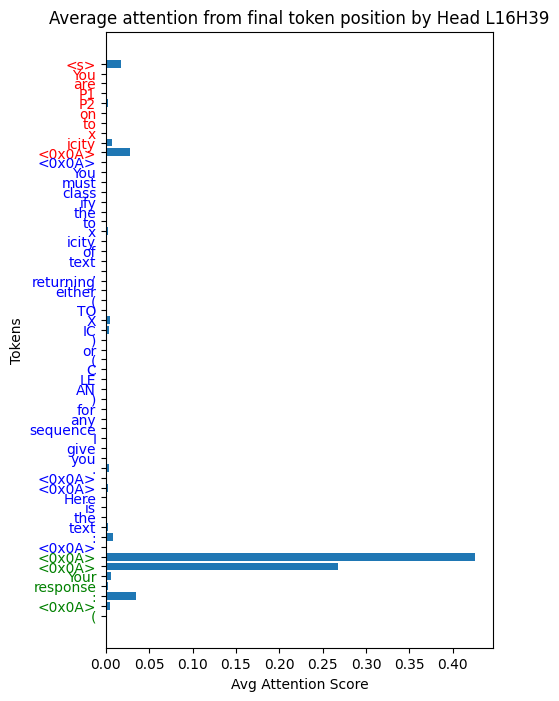

In [247]:
filter = toxicity_results_df["head"] == "L16H39"

results = toxicity_results_df[filter][unique_non_sequence_tokens].mean()
columns = [t.split("_")[0] for t in unique_non_sequence_tokens]  # Adjust this to match your original logic

positions = np.arange(len(columns))  # Positions for the bars

# Plotting with flipped axes
fig, ax = plt.subplots(figsize=(5, 8))
ax.barh(positions, results)  # Notice we are using barh() instead of bar()

ax.set_ylabel('Tokens')  # Y-axis Label (previously x-axis)
ax.set_xlabel('Avg Attention Score')  # X-axis Label (previously y-axis)
ax.set_title('Average attention from final token position by Head L16H39')  # Title
ax.set_yticks(positions)
ax.set_yticklabels(columns)  # We don't need to rotate y-labels since they're already vertical

# Coloring the labels based on the token type
for i, tl in enumerate(ax.get_yticklabels()):  # Notice we are working with y-tick labels here
    if i < len(persona_tokens):
        tl.set_color("red")
    elif i < len(persona_tokens) + len(instruction_tokens1):
        tl.set_color("blue")
    else:
        tl.set_color("green")

ax.invert_yaxis()

plt.show()

In [271]:
def create_attn_barplots(filters, head_name, data=None):
    data = data if data is not None else toxicity_results_df
    fig, axs = plt.subplots(2, 2, figsize=(20, 12))

    # Set overall title
    fig.suptitle(f'Average attention from final token position by {head_name}', fontsize=20)

    # Flatten the axs array for easier iteration
    axs = axs.flatten()

    for idx, (filter_condition, title) in enumerate(filters):
        if idx >= 4:  # Check to not exceed the 4x4 grid
            break

        results = data[filter_condition][unique_non_sequence_tokens].mean()
        columns = [t.split("_")[0] for t in unique_non_sequence_tokens]
        positions = np.arange(len(columns))
        
        ax = axs[idx]  # Select subplot
        
        ax.bar(positions, results)
        
        ax.set_xlabel('Tokens')
        ax.set_ylabel('Avg Attention Score')
        ax.set_title(title)
        
        ax.set_xticks(positions)
        ax.set_xticklabels(columns, rotation=-75)
        
        for i, tl in enumerate(ax.get_xticklabels()):
            if i < len(persona_tokens):
                tl.set_color("red")
            elif i < len(persona_tokens) + len(instruction_tokens1):
                tl.set_color("blue")
            else:
                tl.set_color("green")
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Plots for heads that are probably important for toxicity

In [258]:
most_important_heads_toxicity

[(16, 39), (17, 2), (15, 21), (19, 36), (21, 7)]

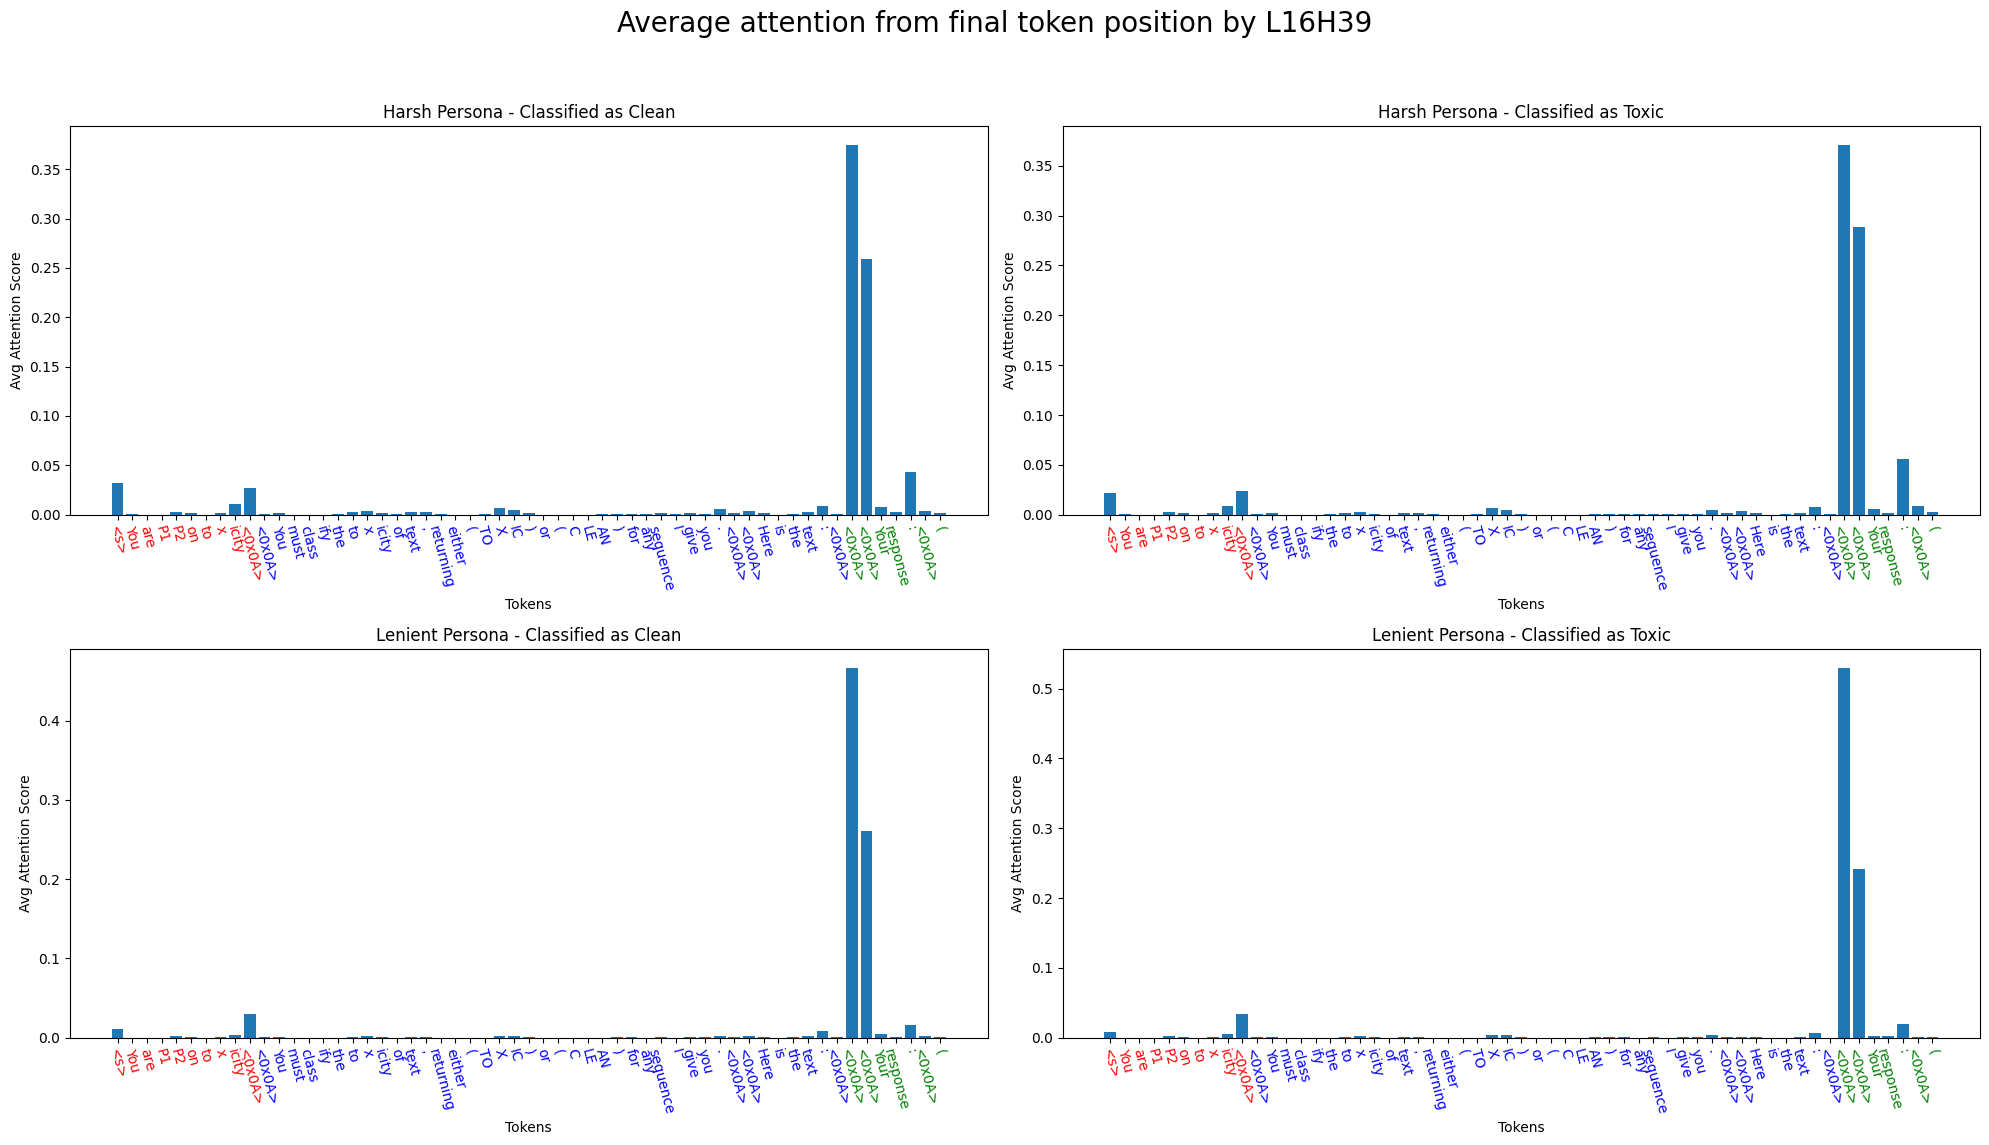

In [262]:
filters = [
    ((toxicity_results_df["head"] == "L16H39") & (toxicity_results_df["persona"] == "harsh") & toxicity_results_df["classified_as_clean"], "Harsh Persona - Classified as Clean"),
    ((toxicity_results_df["head"] == "L16H39") & (toxicity_results_df["persona"] == "harsh") & (~toxicity_results_df["classified_as_clean"]), "Harsh Persona - Classified as Toxic"),
    ((toxicity_results_df["head"] == "L16H39") & (toxicity_results_df["persona"] == "lenient") & toxicity_results_df["classified_as_clean"], "Lenient Persona - Classified as Clean"),
    ((toxicity_results_df["head"] == "L16H39") & (toxicity_results_df["persona"] == "lenient") & (~toxicity_results_df["classified_as_clean"]), "Lenient Persona - Classified as Toxic")
]

create_attn_barplots(filters, "L16H39")

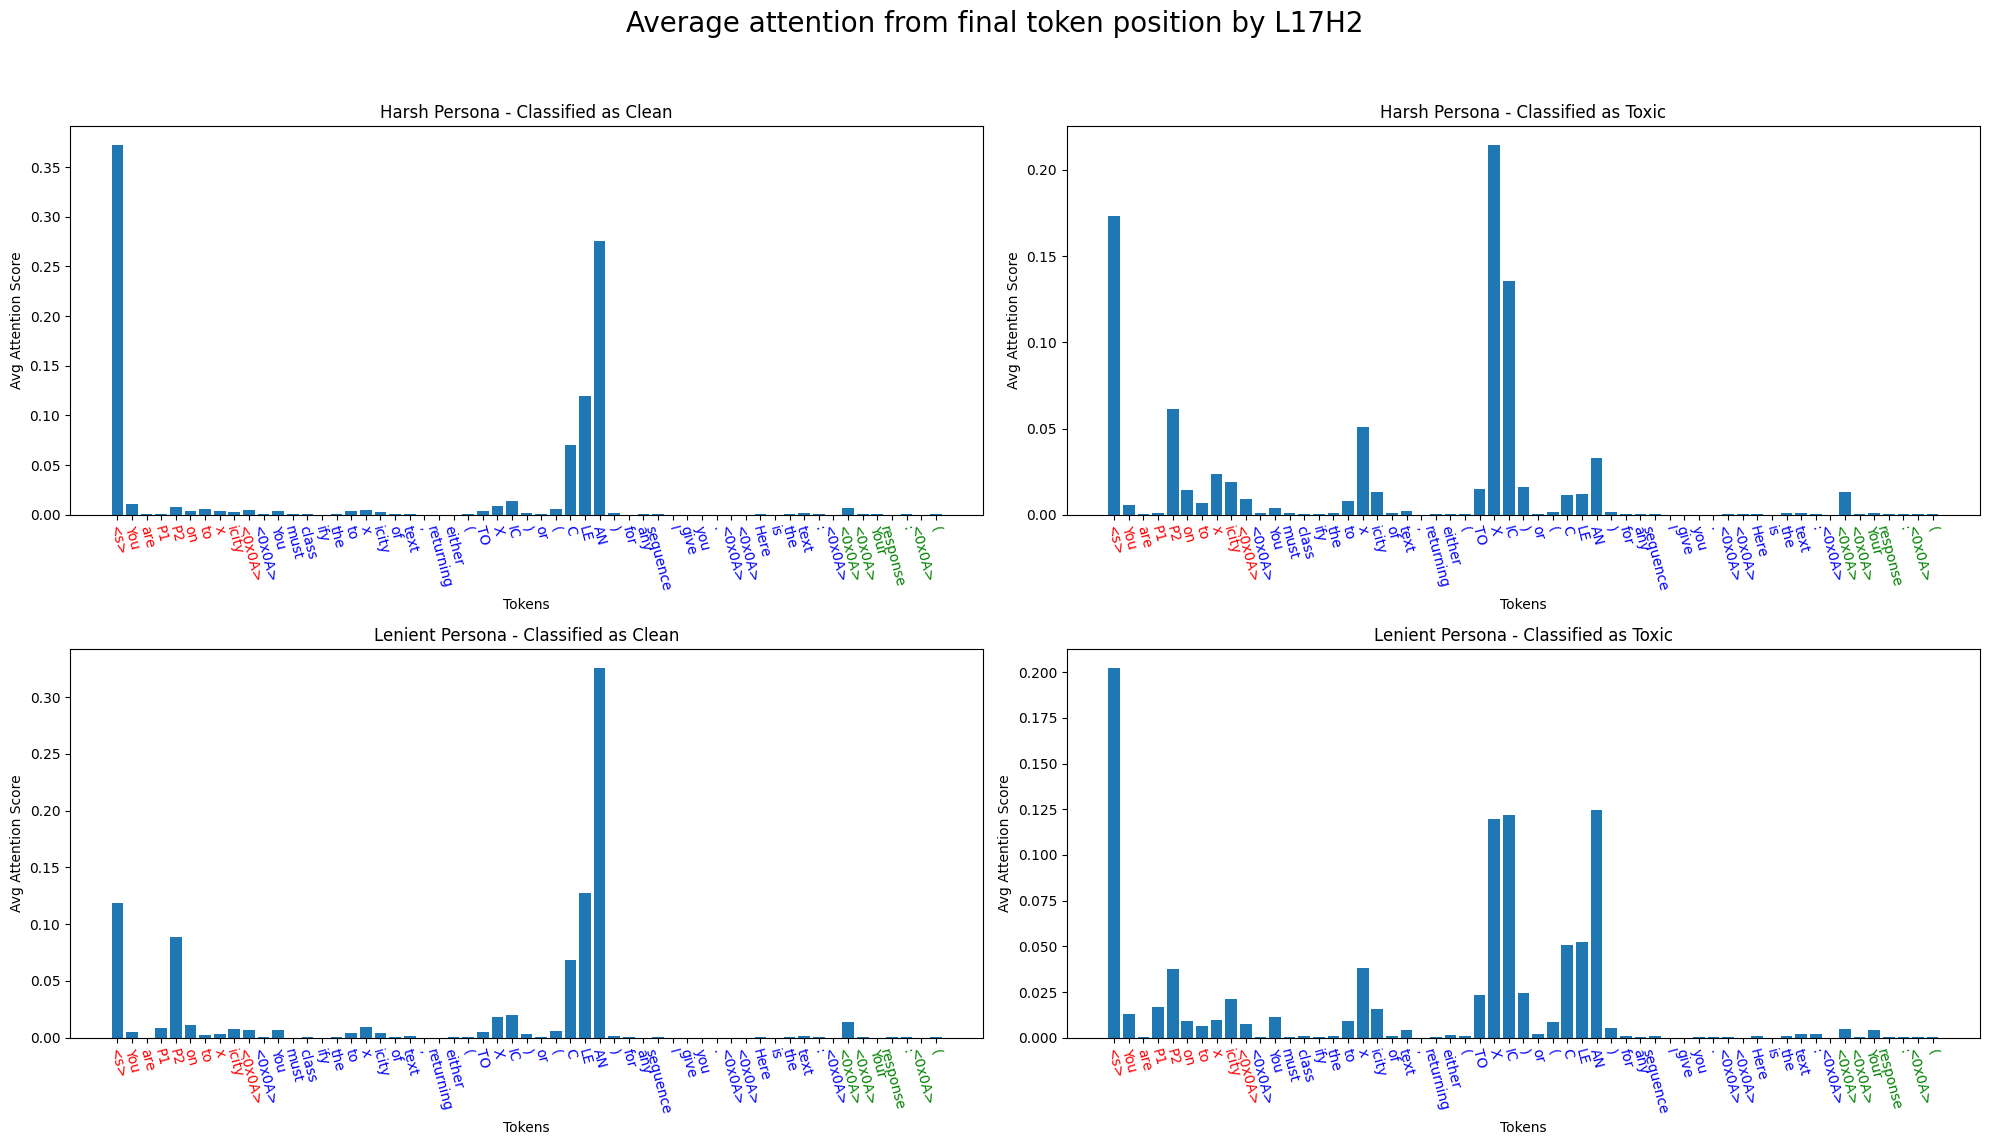

In [263]:
filters = [
    ((toxicity_results_df["head"] == "L17H2") & (toxicity_results_df["persona"] == "harsh") & toxicity_results_df["classified_as_clean"], "Harsh Persona - Classified as Clean"),
    ((toxicity_results_df["head"] == "L17H2") & (toxicity_results_df["persona"] == "harsh") & (~toxicity_results_df["classified_as_clean"]), "Harsh Persona - Classified as Toxic"),
    ((toxicity_results_df["head"] == "L17H2") & (toxicity_results_df["persona"] == "lenient") & toxicity_results_df["classified_as_clean"], "Lenient Persona - Classified as Clean"),
    ((toxicity_results_df["head"] == "L17H2") & (toxicity_results_df["persona"] == "lenient") & (~toxicity_results_df["classified_as_clean"]), "Lenient Persona - Classified as Toxic")
]

create_attn_barplots(filters, "L17H2")

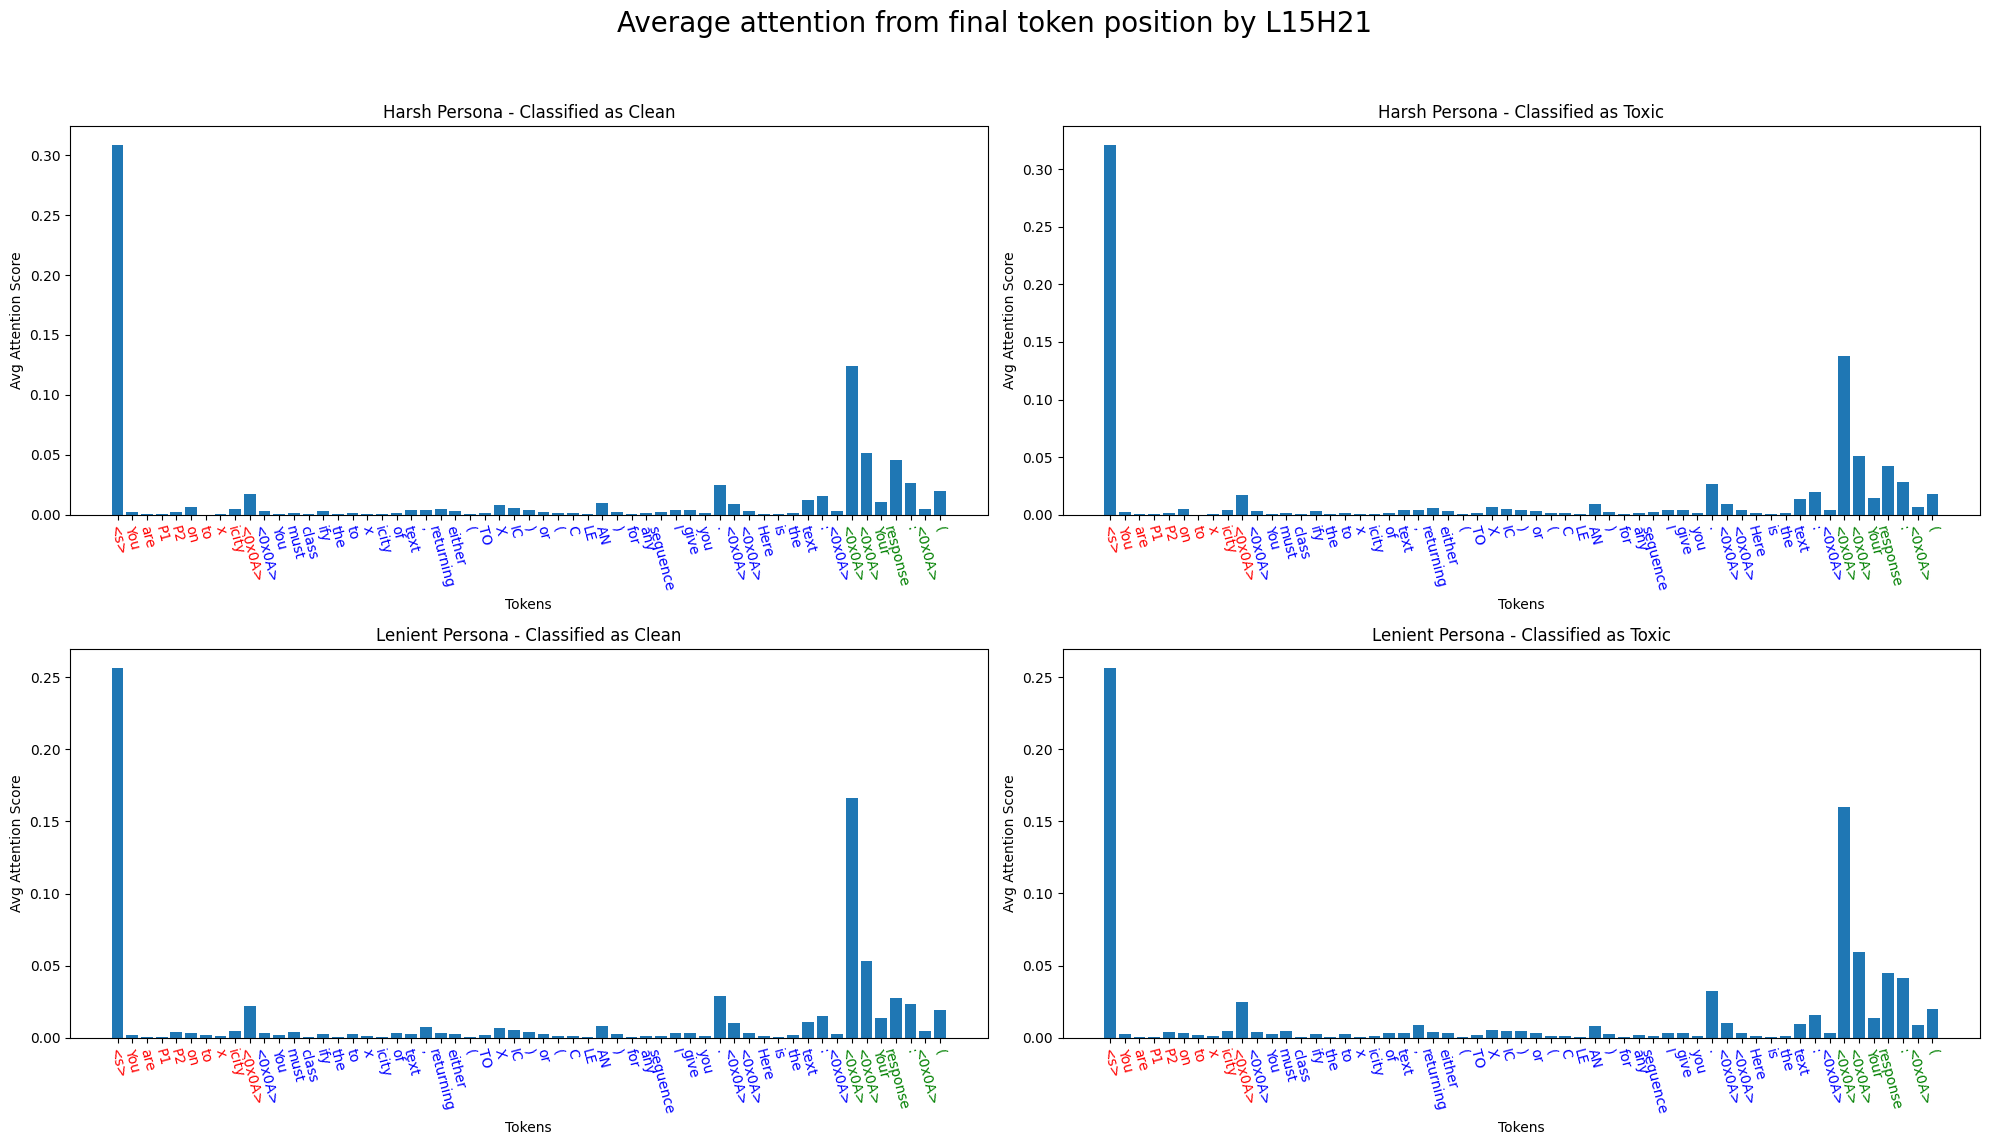

In [264]:
filters = [
    ((toxicity_results_df["head"] == "L15H21") & (toxicity_results_df["persona"] == "harsh") & toxicity_results_df["classified_as_clean"], "Harsh Persona - Classified as Clean"),
    ((toxicity_results_df["head"] == "L15H21") & (toxicity_results_df["persona"] == "harsh") & (~toxicity_results_df["classified_as_clean"]), "Harsh Persona - Classified as Toxic"),
    ((toxicity_results_df["head"] == "L15H21") & (toxicity_results_df["persona"] == "lenient") & toxicity_results_df["classified_as_clean"], "Lenient Persona - Classified as Clean"),
    ((toxicity_results_df["head"] == "L15H21") & (toxicity_results_df["persona"] == "lenient") & (~toxicity_results_df["classified_as_clean"]), "Lenient Persona - Classified as Toxic")
]

create_attn_barplots(filters, "L15H21")

### Plots for heads that are probably important for personas

In [265]:
most_important_heads_persona

[(14, 39), (18, 18), (19, 36), (21, 7), (15, 17)]

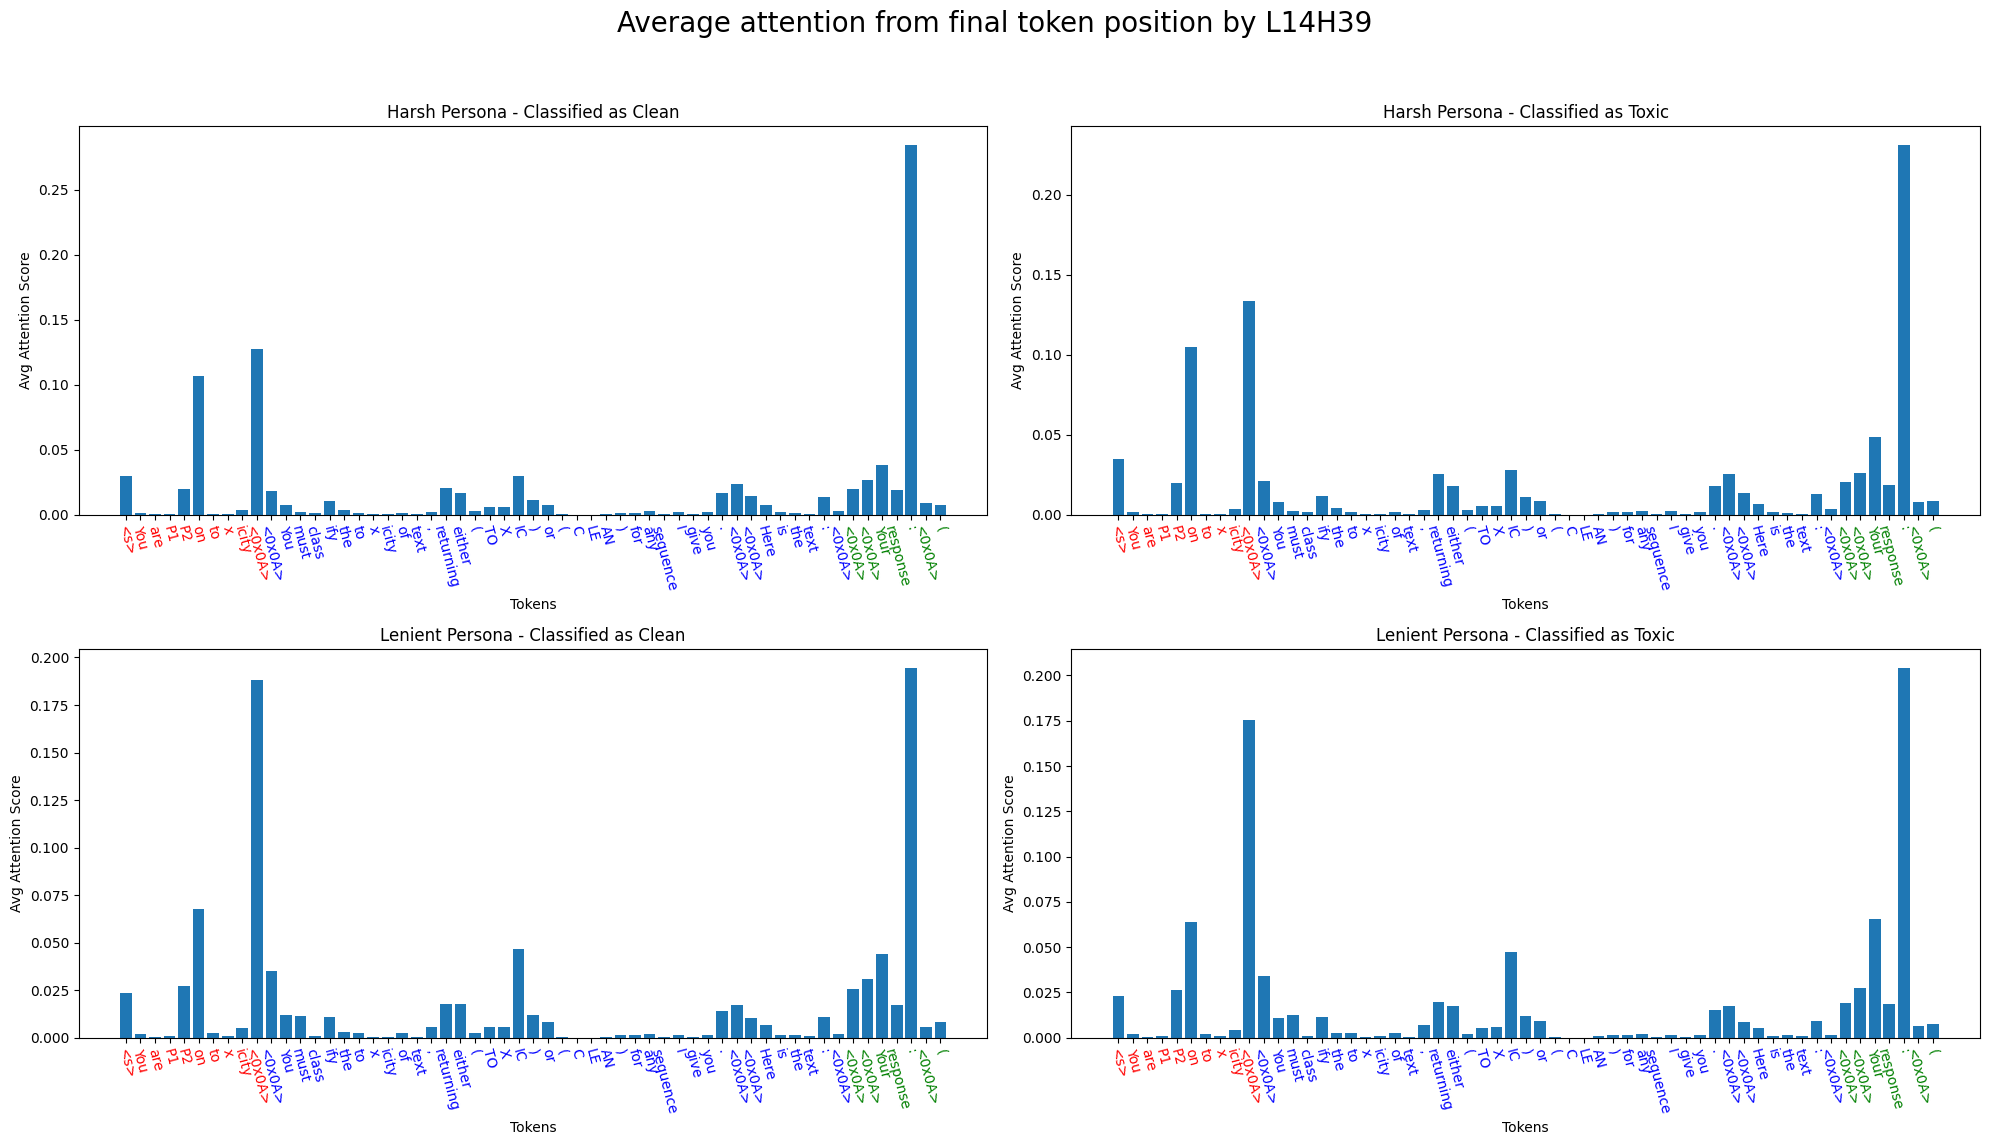

In [274]:
filters = [
    ((persona_results_df["head"] == "L14H39") & (persona_results_df["persona"] == "harsh") & persona_results_df["classified_as_clean"], "Harsh Persona - Classified as Clean"),
    ((persona_results_df["head"] == "L14H39") & (persona_results_df["persona"] == "harsh") & (~persona_results_df["classified_as_clean"]), "Harsh Persona - Classified as Toxic"),
    ((persona_results_df["head"] == "L14H39") & (persona_results_df["persona"] == "lenient") & persona_results_df["classified_as_clean"], "Lenient Persona - Classified as Clean"),
    ((persona_results_df["head"] == "L14H39") & (persona_results_df["persona"] == "lenient") & (~persona_results_df["classified_as_clean"]), "Lenient Persona - Classified as Toxic")
]

create_attn_barplots(filters, "L14H39", data=persona_results_df)

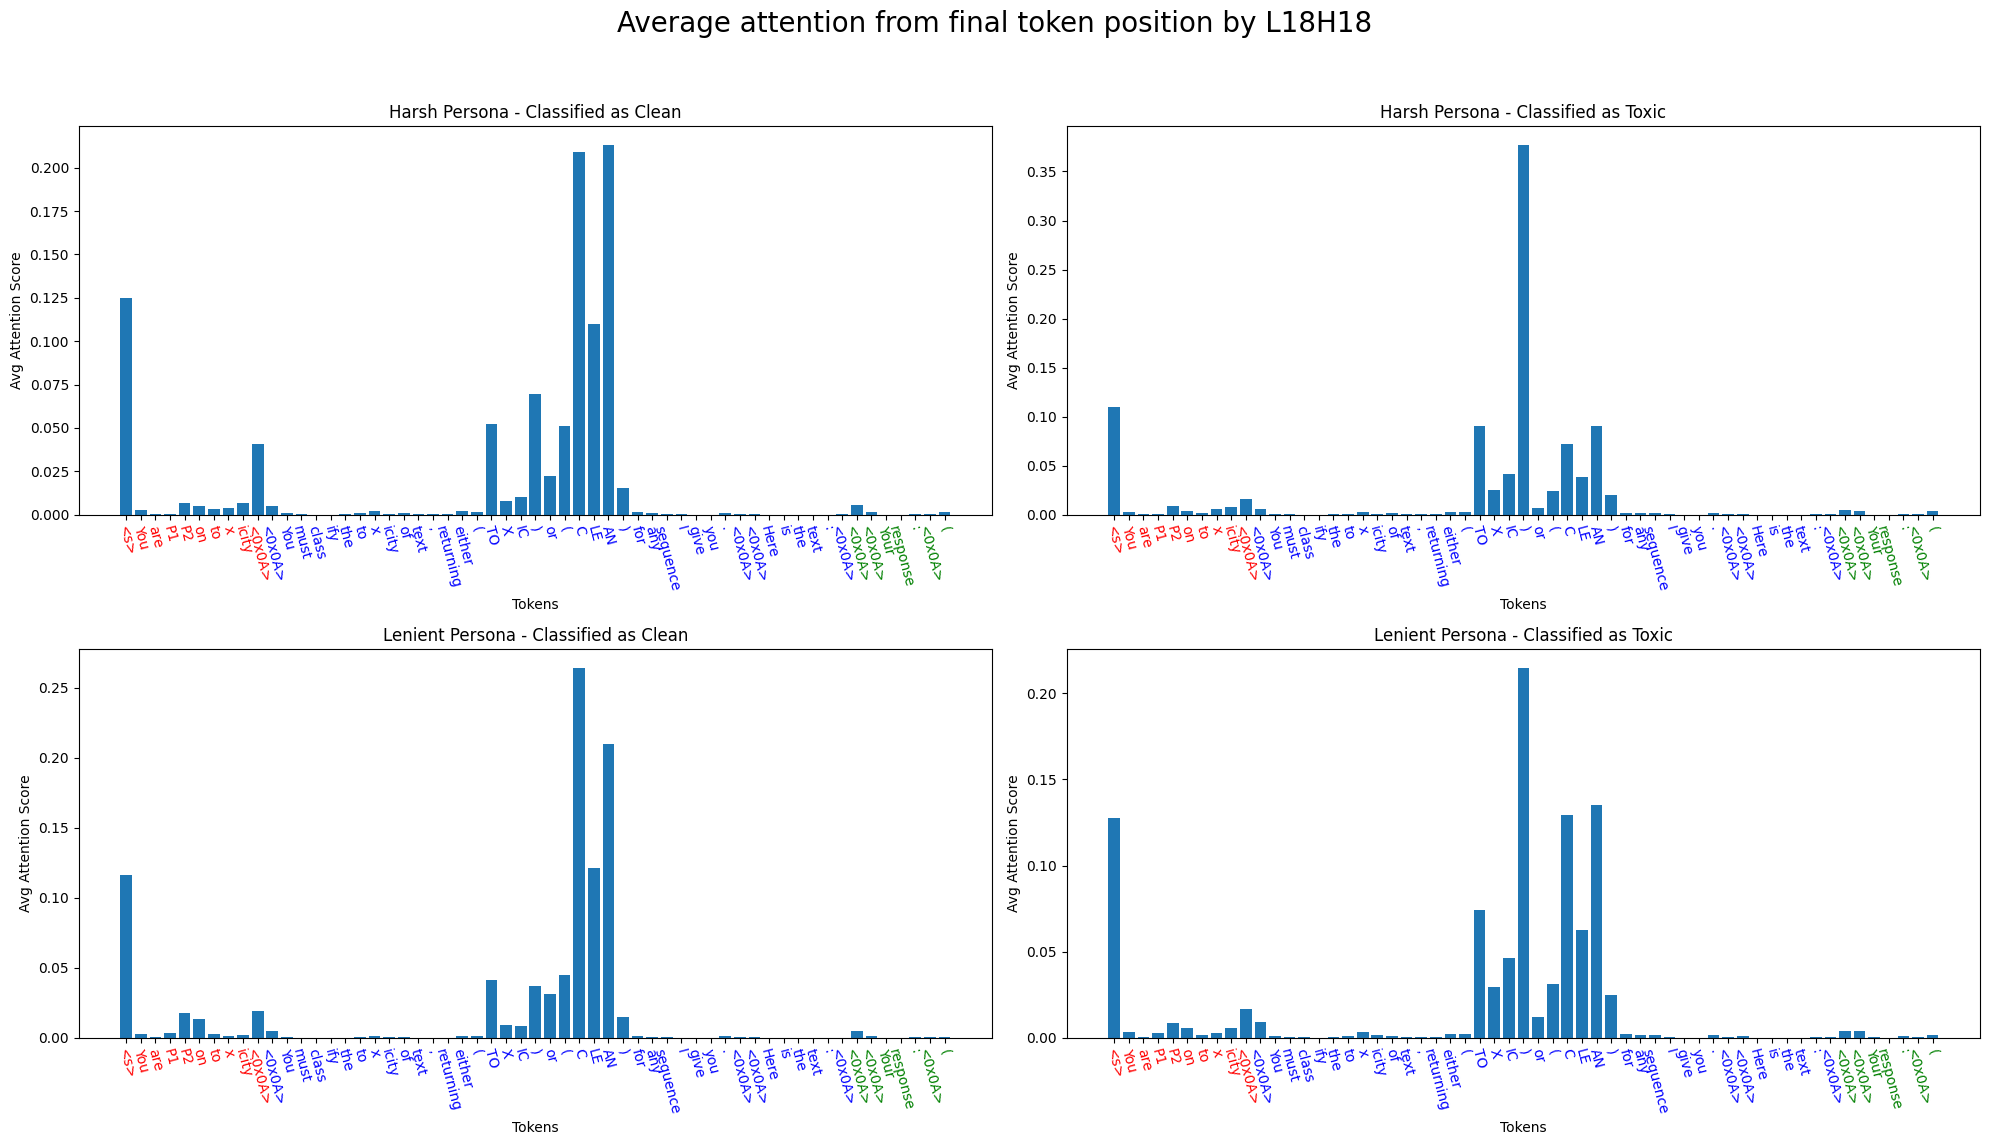

In [275]:
filters = [
    ((persona_results_df["head"] == "L18H18") & (persona_results_df["persona"] == "harsh") & persona_results_df["classified_as_clean"], "Harsh Persona - Classified as Clean"),
    ((persona_results_df["head"] == "L18H18") & (persona_results_df["persona"] == "harsh") & (~persona_results_df["classified_as_clean"]), "Harsh Persona - Classified as Toxic"),
    ((persona_results_df["head"] == "L18H18") & (persona_results_df["persona"] == "lenient") & persona_results_df["classified_as_clean"], "Lenient Persona - Classified as Clean"),
    ((persona_results_df["head"] == "L18H18") & (persona_results_df["persona"] == "lenient") & (~persona_results_df["classified_as_clean"]), "Lenient Persona - Classified as Toxic")
]

create_attn_barplots(filters, "L18H18", data=persona_results_df)

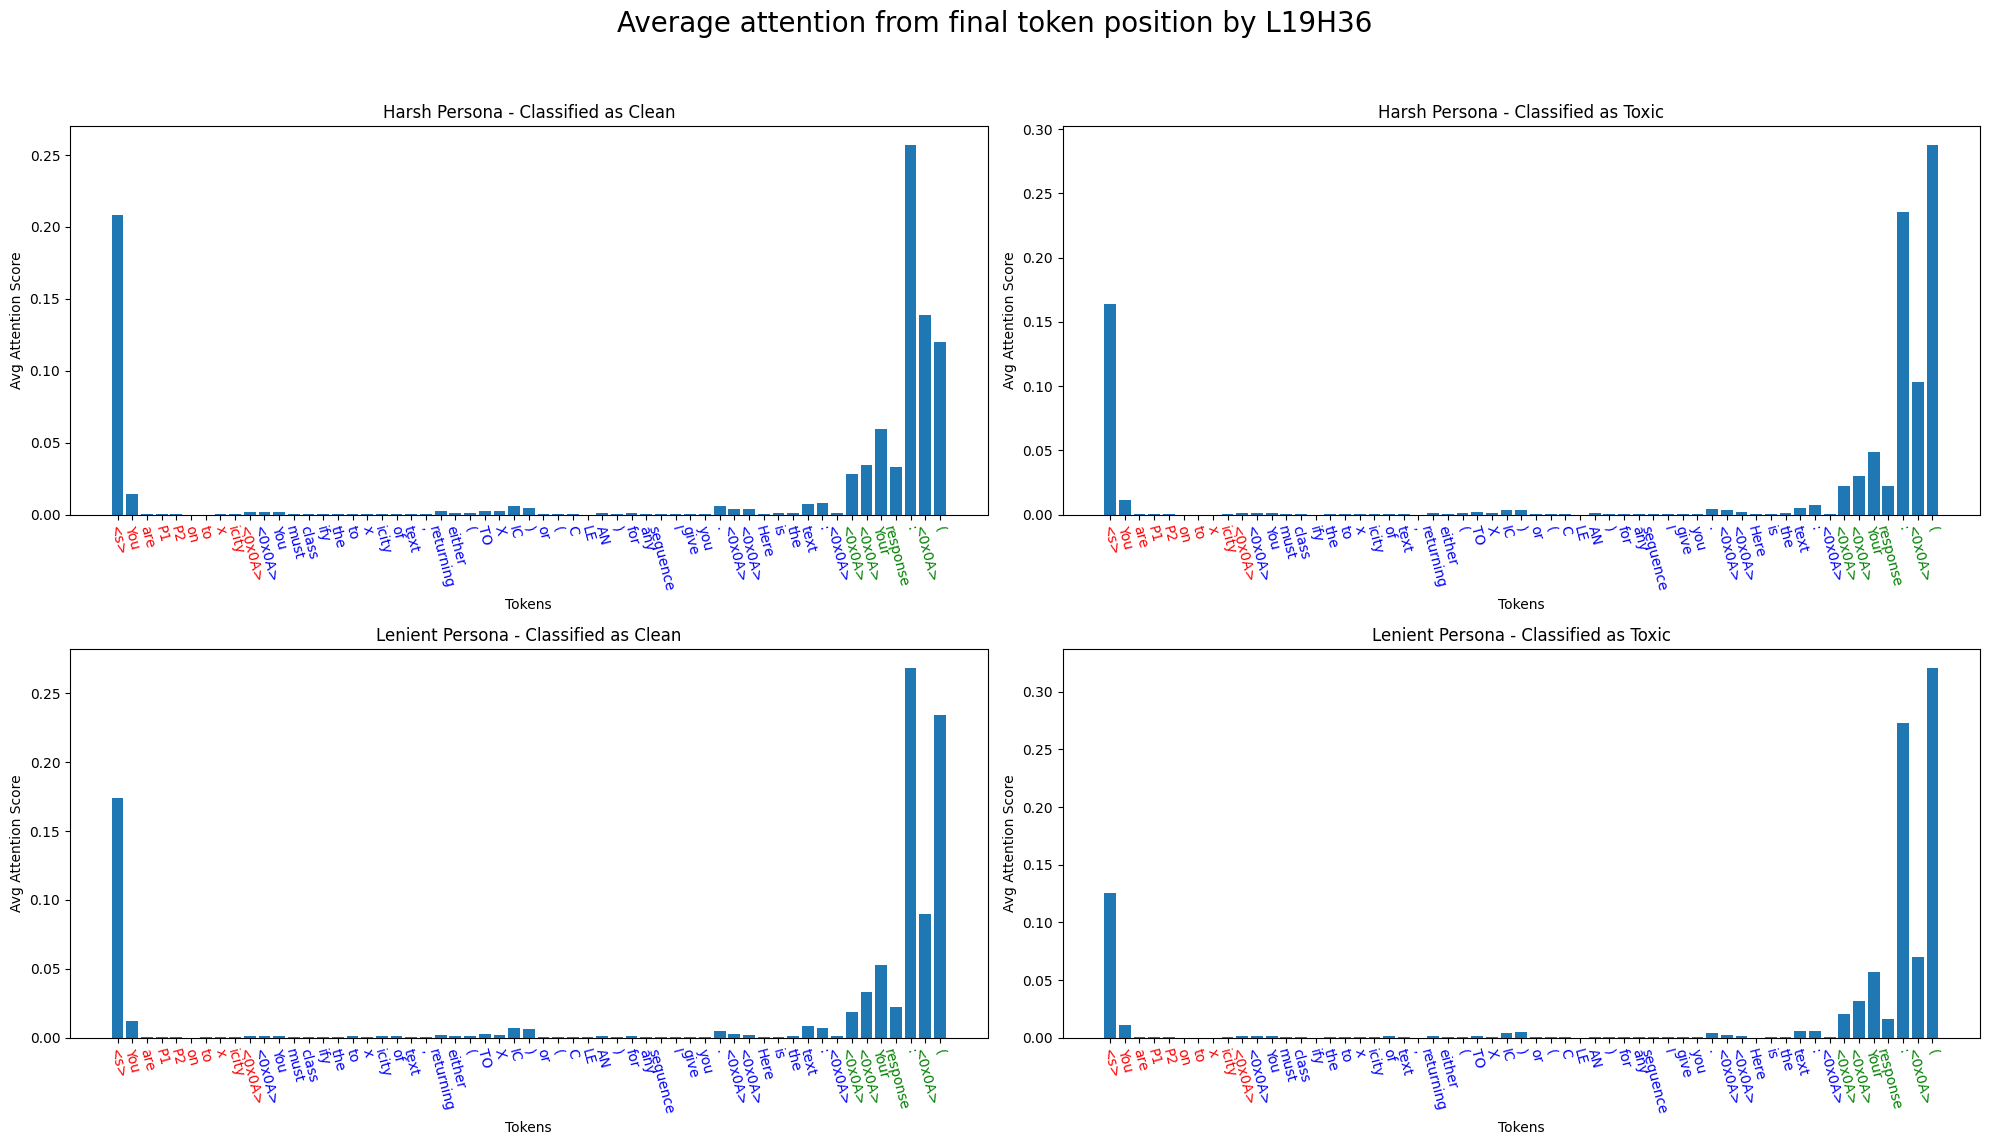

In [276]:
filters = [
    ((persona_results_df["head"] == "L19H36") & (persona_results_df["persona"] == "harsh") & persona_results_df["classified_as_clean"], "Harsh Persona - Classified as Clean"),
    ((persona_results_df["head"] == "L19H36") & (persona_results_df["persona"] == "harsh") & (~persona_results_df["classified_as_clean"]), "Harsh Persona - Classified as Toxic"),
    ((persona_results_df["head"] == "L19H36") & (persona_results_df["persona"] == "lenient") & persona_results_df["classified_as_clean"], "Lenient Persona - Classified as Clean"),
    ((persona_results_df["head"] == "L19H36") & (persona_results_df["persona"] == "lenient") & (~persona_results_df["classified_as_clean"]), "Lenient Persona - Classified as Toxic")
]

create_attn_barplots(filters, "L19H36", data=persona_results_df)